# Following notebook contains code to reproduce graphs found in the paper

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Arial']})
import seaborn as sns
import json
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

### Functions for metadata organization

In [3]:
#filter out nan from list
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list


def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

### Importing metadata from existing csv files

In [4]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# load all data from csvs stored in the repo

#ALLEN INSTITUTE CELL FEATURE METADATA
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)


#GENE EXPRESSION DATA
#transcriptomic gene expression data by cell type including layers (gene number x cre-line w/ layers)
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)


#ION CONDUCTANCE DATA
#relative conductance data for cell types separated by layers (cre-line w/ layers x parameters)
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)


#VGIC LIST
#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)


#SPEARMAN CORRELATION RANKS
#Spearman Correlation ranks for cell types and relative conductance
f = open("new_sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()



#BASIC METADATA
#cre line basic metadata, including subclasses, colours
cre_line_metadata = pd.read_csv("data/cre_line_info.csv", index_col=0)


#CSV file containing list of names, colours for corresponding cre-line, related VGIC to conductance parameter
org = pd.read_csv("org.csv", index_col=0)

#Parameter names
parameters = list(org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = filter_out_nan(list(org['shared']))

#Dictionary of the related genes to the 6 parameters
related_RNA = {}
for para in shared_parameters:
    related_RNA[para] = filter_out_nan(list(org[para]))
list_temp = related_RNA['gbar_Ih']
list_temp.remove('Hcn4')
related_RNA['gbar_Ih'] = list_temp
#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)
gene_channel_vgic = ion_channel_genes.loc["vgic"]

#List of gene channels that have expression of more than .1
exclude = [] #filter out gene expression less than .1
for gene in list(gene_channel_vgic['Mouse Entrez Gene']):
    if int(gene) in list(transcriptome_df.index):
        if sum(list(transcriptome_df.loc[int(gene)]))/len(list(transcriptome_df.loc[int(gene)])) < .1:
            exclude.append(gene)
for excluded_gene in exclude:
    gene_channel_vgic_filtered = gene_channel_vgic[gene_channel_vgic['Mouse Entrez Gene'] != excluded_gene]

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))
cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
#Set-up for palette for cell types based on shortened Cre-line name
shortened_color = filter_out_nan(list(org['short']))
shortened_palette = palette_builder(shortened_color, list(org['colour']))
#Set-up for palette for cell types based on class
color_inh = filter_out_nan(list(cre_line_metadata['class_colour']))
#Set-up for palette for cell types based on subclass
color_sub = filter_out_nan(list(cre_line_metadata['subclass_colour']))
class_inh = filter_out_nan(list(cre_line_metadata['class']))
subclasses = filter_out_nan(list(cre_line_metadata['subclass']))

### Function for calculating standard error and standard deviation for each parameter

In [5]:
#calculate the standard deviation and sem
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

#set sem and std to the values for standard deviation and sem for relative
sem, std = cal_std_sem(parameters)


### Functions for creating ion parameter x gene expression matrix

In [6]:
#HELPER FUNCTIONS
#creating the data for specific ion parameter of cre-lines
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

#creating the data for specific gene expression of cre-lines
def create_gene_spec_filtered(gene_symbol):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    gene_spec = transcriptome_df.loc[gene_id]
    gene_spec_filtered = pd.DataFrame(gene_spec.loc[cre_color_inc_4])
    return gene_spec_filtered, gene_id

#function for renaming into shortened cre-line
def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)
    
    
#creating ion parameter x gene expression matrix
def create_graph_spec(parameter_type, gene_symbol, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol)
    
    graph_spec = pd.concat([cre_conductance_filtered, gene_spec_filtered], axis = 1)
    
    rename_graph_spec(graph_spec)
    
    return graph_spec

### Function for graphing ion parameter x gene expression

In [7]:
#Graphing scatterplot of conductance and transcriptomics
def graph_conductance_exp(parameter_type, gene_symbol, df, xlabel, ylabel, 
                                show_errorbars = True,
                                show_legend = True, 
                                show_best_line = True, 
                                poly_deg = 2, # degree of polynomial for fit
                               add_corr_val_to_plot = False
                               ):
    
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene']) #gene
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) #matrix

    # get standard errors
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    
    # get the max and min values for gene expression
    graph_spec.sort_values(by=[gene_id], inplace = True)
    mini = graph_spec.iloc[0, :][gene_id]
    maxi = graph_spec.iloc[14, :][gene_id]
    
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) #unsort 
    
    # best fit line
    if(show_best_line):
        z = np.polyfit(x= graph_spec[gene_id], y=np.log(graph_spec[parameter_type]), deg=1)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        _ = plt.plot(xp, np.exp(p(xp)), '-', zorder=1)
    
    # plot data points
    ax = sns.scatterplot(x=gene_id, y=parameter_type, 
                         hue=shortened_color, data=graph_spec,
                         s = 100, palette=shortened_palette, zorder=3)
    
    # add corr val to plot
    if (add_corr_val_to_plot):
        corr_val = sep_spearman_corr_ranks[parameter_type][gene_symbol]
        corr_text = 'rho= %01.2f' % corr_val
        ax.text(.37, .95, corr_text,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=15) #add text
    
    # legend handling
    if (show_legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    else:
        ax.get_legend().remove()
    
    # spine and tick handling
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # setting axis labels
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    # setting error bars
    if (show_errorbars):
        # Find the x,y coordinates for each point for errorbar plotting
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
    return ax

### Functions needed for creating histograms showing gene corr specificity

In [8]:
#creating matrix for spearman correlation in gene expression of a specific parameter type
def create_matrix_select(parameter, spearman_dict, list_possible):
    d = {"symbol":[], "correlation":[]}
    i = 0
    check = list(spearman_dict[parameter].keys()) #ensure that gene number is availble in the VGIC list
    for stuff in list_possible:
        if stuff in check:
            correl = spearman_dict[parameter][stuff]
            d['symbol'].append(stuff)
            d['correlation'].append(correl)
            i = i + 1
    test = pd.DataFrame(d)
    return test.sort_values(by=['correlation'])

#creating the histogram for spearman corrleations of specific parameter
def histo_corr_new(parameter, df, xlabel, ylabel, y_max_val = 1):
    test = create_matrix_select(parameter, df, gene_channel)
    sorted_test = test.sort_values(["correlation"], ascending=True)
    
    #colouring relevant ion channels as red, rest as blue
    clrs = []
    pos = []
    label = []
    p = 0
    for item in sorted_test['symbol']:
        if item in related_RNA[parameter]:
            clrs.append('blue')
            pos.append(p)
            label.append(item)
            p += 1
        else:
            clrs.append('red')
            p += 1

    ax = sns.barplot(x = 'symbol', y='correlation', data=sorted_test ,palette = clrs)

    # spine and tick handling
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # setting axis labels
    ax.set(ylabel=ylabel, xlabel=xlabel)
    
    #setting y limit
    ax.axes.set_ylim([-y_max_val, y_max_val])
    
    return ax


## Constructing graph of parameter Kv3.1 with its related gene channels and corr specificity histogram

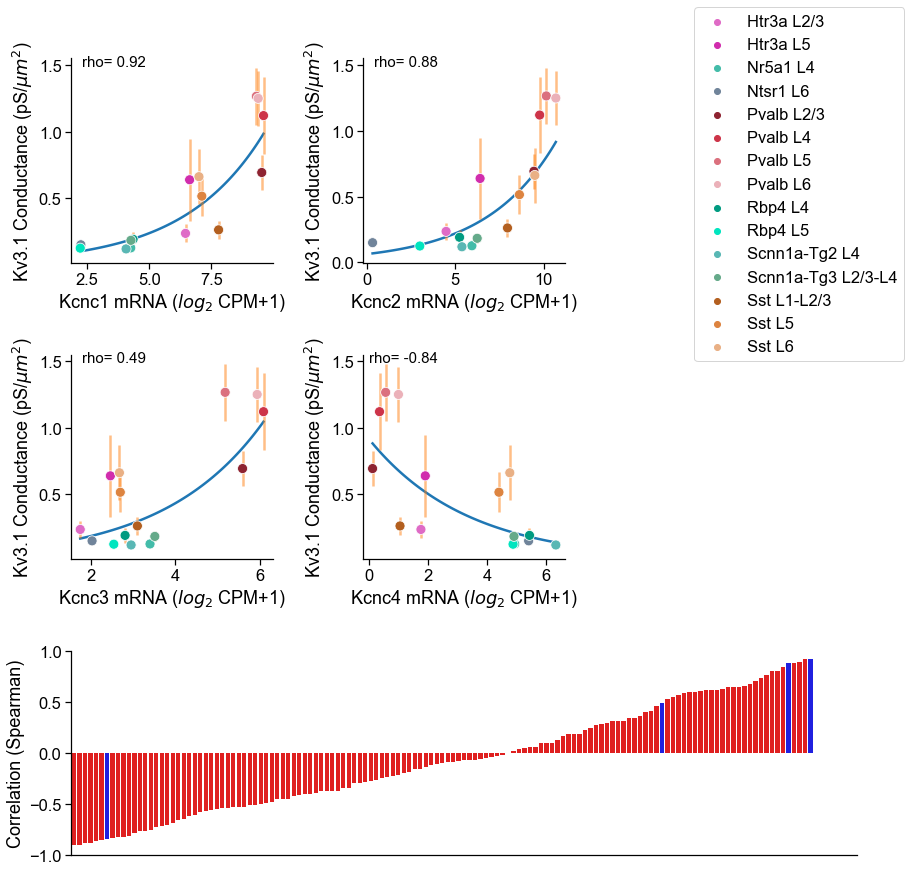

In [10]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc3', sep_layer_cre_parameter_df, 'Kcnc3 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_conductance_exp('gbar_Kv3_1', 'Kcnc4', sep_layer_cre_parameter_df, 'Kcnc4 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax5 = fig.add_subplot(grid[2, :])
ax5 = histo_corr_new('gbar_Kv3_1', sep_spearman_corr_ranks, 'VGCCs', 'Correlation (Spearman)')

handles, labels = ax4.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right')


## Constructing graph of parameter Ih with its related gene channels and corr specificity histogram

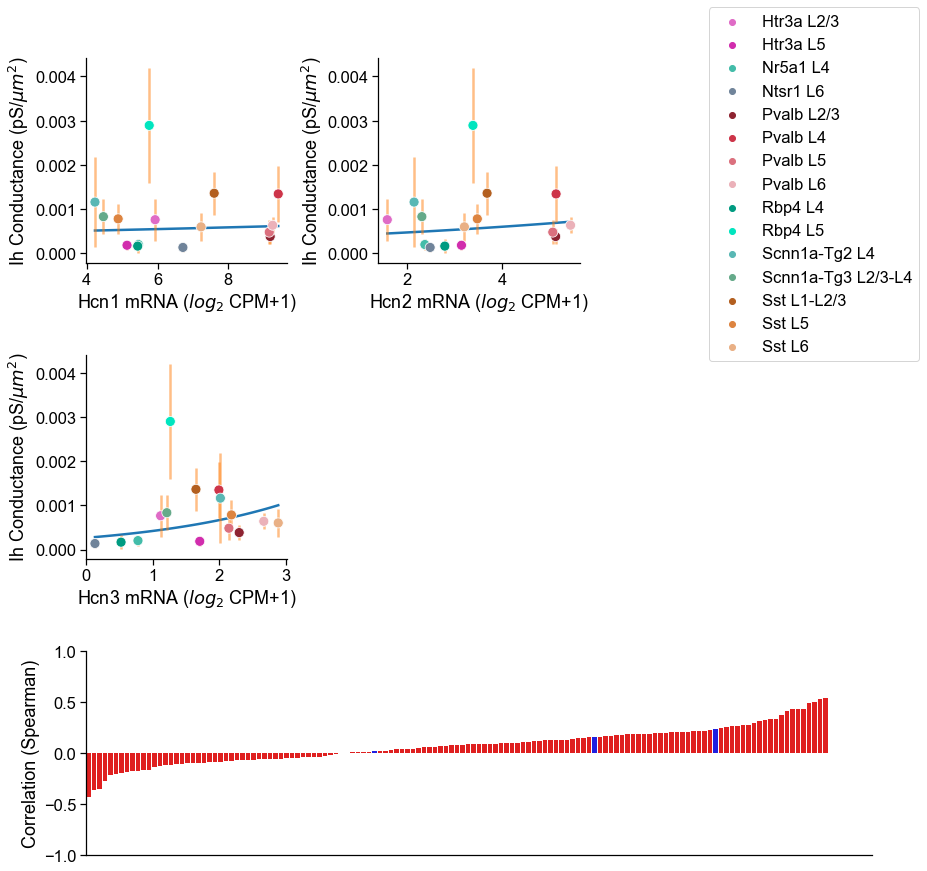

In [23]:
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_Ih', 'Hcn1', sep_layer_cre_parameter_df, 'Hcn1 mRNA ($log_2$ CPM+1)', 'Ih Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_conductance_exp('gbar_Ih', 'Hcn2', sep_layer_cre_parameter_df, 'Hcn2 mRNA ($log_2$ CPM+1)', 'Ih Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_conductance_exp('gbar_Ih', 'Hcn3', sep_layer_cre_parameter_df, 'Hcn3 mRNA ($log_2$ CPM+1)', 'Ih Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)

ax5 = fig.add_subplot(grid[2, :])
ax5 = histo_corr_new('gbar_Ih', sep_spearman_corr_ranks, 'VGCCs', 'Correlation (Spearman)')

handles, labels = ax3.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right')
fig.savefig('figures/Ih_fig.pdf', transparent=True)

## K_T and Kcnd Family Graph

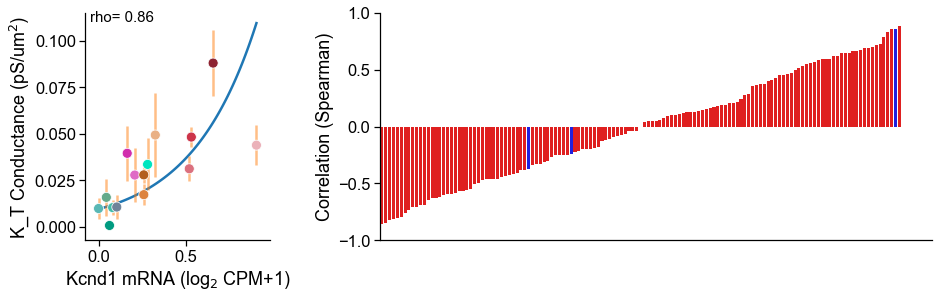

In [11]:
ncols = 2
nrows = 1
fig = plt.figure(figsize = (14, 4))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3, width_ratios=[1,3])


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_K_T', 'Kcnd1', sep_layer_cre_parameter_df, 
                            'Kcnd1 mRNA (log$_2$ CPM+1)', 'K_T Conductance (pS/um$^2$)', 
                            show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = histo_corr_new('gbar_K_T', sep_spearman_corr_ranks, 'K_T correlation with VGIC mRNAs',
                     'Correlation (Spearman)')
fig.savefig('figures/K_T_fig.pdf', transparent=True)

## SK and Kcnn2 family graph 

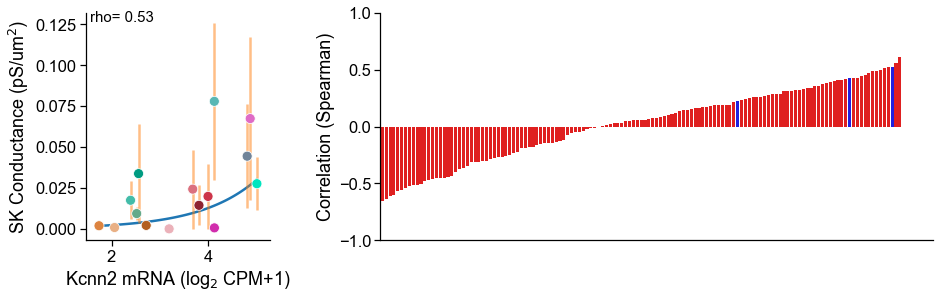

In [12]:
ncols = 2
nrows = 1
fig = plt.figure(figsize = (14, 4))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3, width_ratios=[1,3])


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 
                            'Kcnn2 mRNA (log$_2$ CPM+1)', 'SK Conductance (pS/um$^2$)', show_legend= False, poly_deg=2, 
                           add_corr_val_to_plot=True)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = histo_corr_new('gbar_SK', sep_spearman_corr_ranks, 'SK correlation with VGIC mRNAs',
                     'Correlation (Spearman)')

fig.savefig('figures/SK_fig.pdf', transparent=True)


### Functions for plotting ion conductance and gene expression relative to classes and subclasses

In [13]:
# Plotting excitatory and inhibitory sorted gene conductance pairing
def return_graph_conductance_exp_inh(parameter_type, gene_symbol, df, xlabel, ylabel):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

    graph_spec['Address'] = class_inh
    graph_spec['color'] = color_inh

    graph_spec.index = range(15)
    graph_spec.rename(columns={gene_id: gene_symbol}, inplace= True)
    
    graph_spec.sort_values(by='Address', inplace = True)
    
    x = graph_spec[gene_symbol]
    x_exc = graph_spec[gene_symbol][:6]
    x_inh = graph_spec[gene_symbol][6:]
    y_exc = graph_spec[parameter_type][:6]
    y_inh = graph_spec[parameter_type][6:]  
    
    fit_exc = np.polyfit(x_exc, y_exc, deg = 1) #linear fit for excitatory 
    fit_inh = np.polyfit(x_inh, y_inh, deg = 1) #linear fit for inhibitory

    ax = plt

    ax.scatter(x_exc, y_exc, s = 100, alpha = 0.3, c = graph_spec['color'][:6], marker = 'D')
    ax.scatter(x_inh, y_inh, s = 100, alpha = 0.3, c = graph_spec['color'][6:], marker = 'o')
    
    #Setting axis labels
    ax.xlabel(xlabel)
    ax.ylabel(ylabel)
    
    #setting legend
    ax.legend(labels=["excitatory", "inhibitory"], loc="upper left")
    
    lim = pd.Series([min(x), max(x)])
    lim_exc = pd.Series([min(x_exc), max(x_exc)])
    lim_inh = pd.Series([min(x_inh), max(x_inh)])
    ax.plot(lim_exc, lim_exc * fit_exc[0] + fit_exc[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[0])
    ax.plot(lim_inh, lim_inh * fit_inh[0] + fit_inh[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[6])
    
    ax.tick_params(axis = 'both', length=0, width=0)

    return ax


# Plotting subclasses sorted gene conductance pairing
def return_graph_conductance_exp_type(parameter_type, gene_symbol, df, xlabel, ylabel):
    
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    

    graph_spec['subclass'] = subclasses
    graph_spec['subclass'].replace({"Nr5a1": "Pyr", "Ntsr1": "Pyr", "Rbp4" : "Pyr", "Scnn1a-Tg2" : "Pyr", "Scnn1a-Tg3" : "Pyr"}, inplace=True)
    graph_spec['color'] = color_sub
    
    graph_spec.index = range(15)
    graph_spec.rename(columns={gene_id: gene_symbol}, inplace= True)
    
    graph_spec.sort_values(by='subclass', inplace = True)

    x = graph_spec[gene_symbol]
    x_Htr = graph_spec[gene_symbol][:2]
    x_PV = graph_spec[gene_symbol][2:6]
    x_Pyr = graph_spec[gene_symbol][6:12]
    x_Sst = graph_spec[gene_symbol][12:15]
    y_Htr = graph_spec[parameter_type][:2]
    y_PV = graph_spec[parameter_type][2:6]
    y_Pyr = graph_spec[parameter_type][6:12]
    y_Sst = graph_spec[parameter_type][12:15]
    
    
    fit_Htr = np.polyfit(x_Htr, y_Htr, deg = 1)
    fit_PV = np.polyfit(x_PV, y_PV, deg = 1)
    fit_Pyr = np.polyfit(x_Pyr, y_Pyr, deg = 1)
    fit_Sst = np.polyfit(x_Sst, y_Sst, deg = 1)
        
    ax = plt

    ax.scatter(x_Htr, y_Htr, s = 100, alpha = 0.3, c = graph_spec['color'][:2], marker = 'o')
    ax.scatter(x_PV, y_PV, s = 100, alpha = 0.3, c = graph_spec['color'][2:6], marker = 'o')
    ax.scatter(x_Pyr, y_Pyr, s = 100, alpha = 0.3, c = graph_spec['color'][6:12], marker = 'o')
    ax.scatter(x_Sst, y_Sst, s = 100, alpha = 0.3, c = graph_spec['color'][12:15], marker = 'o')
    
    #Setting axis labels
    ax.xlabel(xlabel)
    ax.ylabel(ylabel)
    
    #setting legend
    ax.legend(labels=["Htr3", "PV", "Pyr", "SST"], loc="upper left")
    
    lim = pd.Series([min(x), max(x)])
    lim_Htr = pd.Series([min(x_Htr), max(x_Htr)])
    lim_PV = pd.Series([min(x_PV), max(x_PV)])
    lim_Pyr = pd.Series([min(x_Pyr), max(x_Pyr)])
    lim_Sst = pd.Series([min(x_Sst), max(x_Sst)])
    ax.plot(lim_Htr, lim_Htr * fit_Htr[0] + fit_Htr[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[0])
    ax.plot(lim_PV, lim_PV * fit_PV[0] + fit_PV[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[2])
    ax.plot(lim_Pyr, lim_Pyr * fit_Pyr[0] + fit_Pyr[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[6])
    ax.plot(lim_Sst, lim_Sst * fit_Sst[0] + fit_Sst[1], 'k-', linewidth = 1, c=graph_spec['color'].iloc[12])
        
    ax.tick_params(axis = 'both', length=0, width=0)
    
    return ax
    

## Kcnc1, Kcnc2, Kcnd1, Kcnn2 correspondance graph with class/ subclass subplots

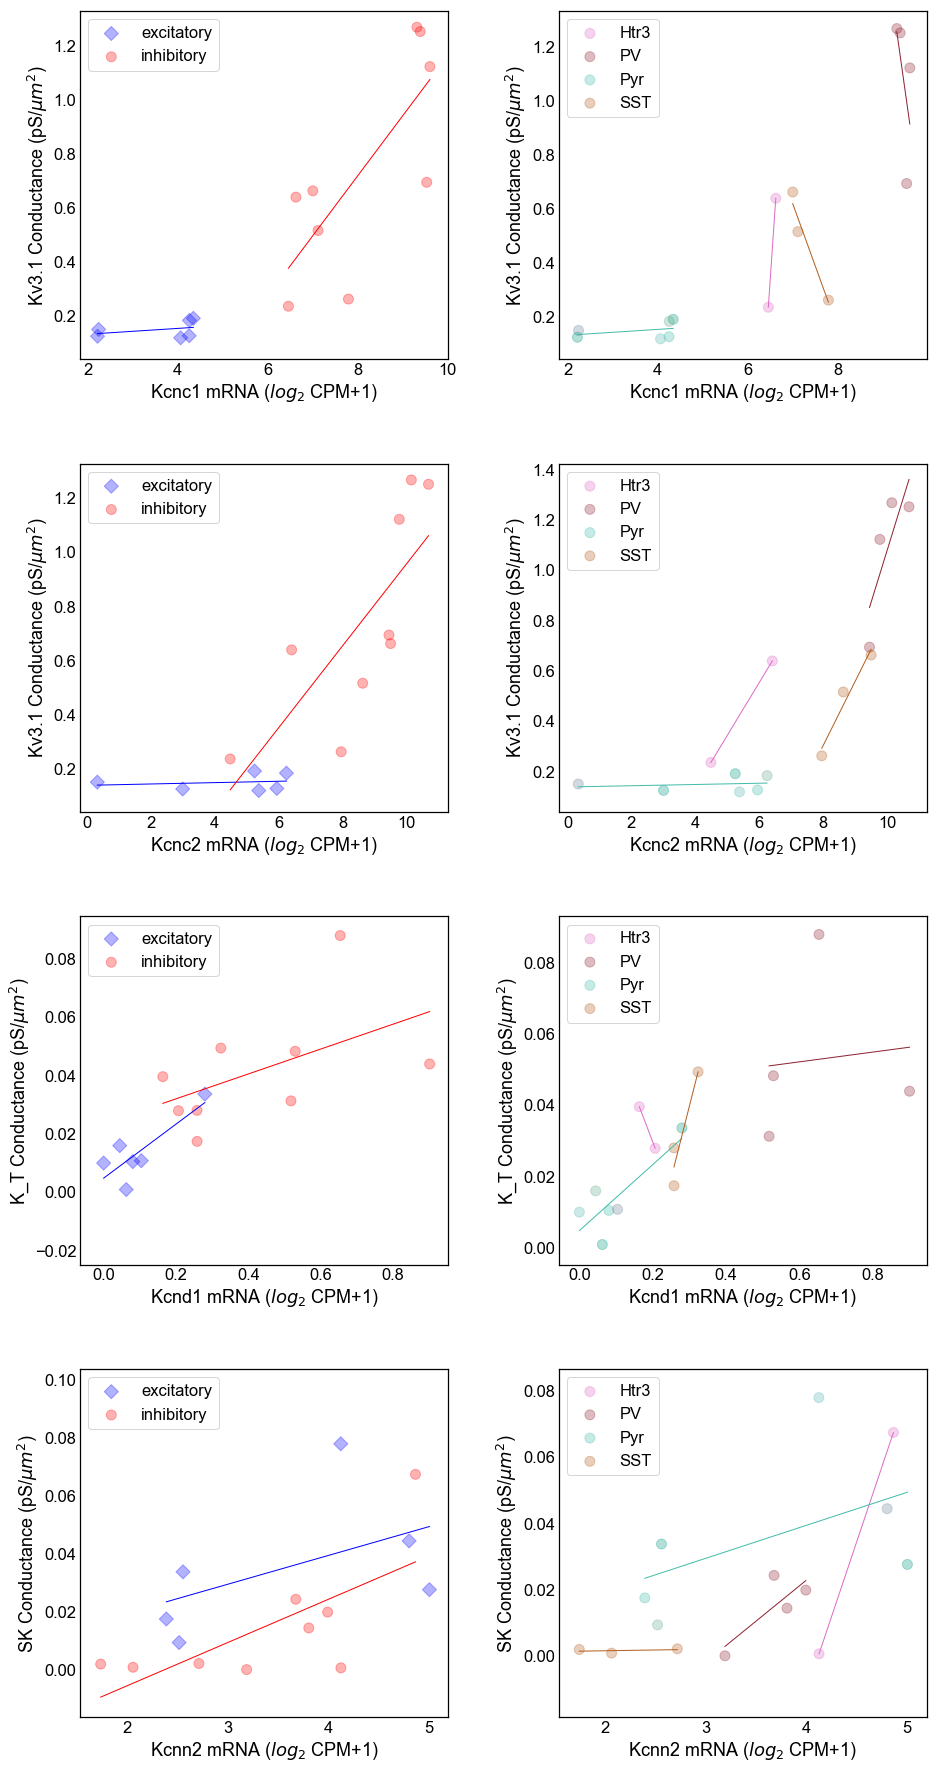

In [14]:
ncols = 2
nrows = 4
fig = plt.figure(figsize = (14, 30))
plt.tight_layout()


grid = gridspec.GridSpec(nrows, ncols,
               left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(grid[0, 0])
ax1 = return_graph_conductance_exp_inh('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

ax2 = fig.add_subplot(grid[0, 1])
ax2 = return_graph_conductance_exp_type('gbar_Kv3_1', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

ax3 = fig.add_subplot(grid[1, 0])
ax3 = return_graph_conductance_exp_inh('gbar_Kv3_1', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

ax4 = fig.add_subplot(grid[1, 1])
ax4 = return_graph_conductance_exp_type('gbar_Kv3_1', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)')

ax5 = fig.add_subplot(grid[2, 0])
ax5 = return_graph_conductance_exp_inh('gbar_K_T', 'Kcnd1', sep_layer_cre_parameter_df, 'Kcnd1 mRNA ($log_2$ CPM+1)', 'K_T Conductance (pS/$\mu m^2$)')

ax6 = fig.add_subplot(grid[2, 1])
ax6 = return_graph_conductance_exp_type('gbar_K_T', 'Kcnd1', sep_layer_cre_parameter_df, 'Kcnd1 mRNA ($log_2$ CPM+1)', 'K_T Conductance (pS/$\mu m^2$)')

ax7 = fig.add_subplot(grid[3, 0])
ax7 = return_graph_conductance_exp_inh('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')

ax8 = fig.add_subplot(grid[3, 1])
ax8 = return_graph_conductance_exp_type('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'SK Conductance (pS/$\mu m^2$)')


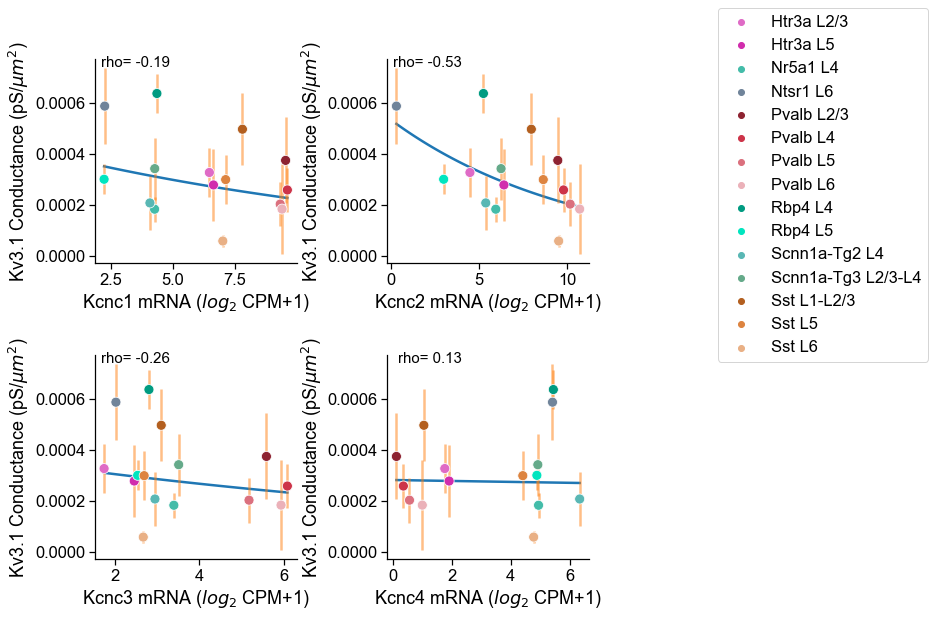

In [11]:
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1 = graph_conductance_exp('soma_g_pas', 'Kcnc1', sep_layer_cre_parameter_df, 'Kcnc1 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax2 = fig.add_subplot(grid[0, 1])
ax2 = graph_conductance_exp('soma_g_pas', 'Kcnc2', sep_layer_cre_parameter_df, 'Kcnc2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax3 = fig.add_subplot(grid[1, 0])
ax3 = graph_conductance_exp('soma_g_pas', 'Kcnc3', sep_layer_cre_parameter_df, 'Kcnc3 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)

ax4 = fig.add_subplot(grid[1, 1])
ax4 = graph_conductance_exp('soma_g_pas', 'Kcnc4', sep_layer_cre_parameter_df, 'Kcnc4 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2, add_corr_val_to_plot=True)


handles, labels = ax4.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right')
